# Load Packages

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

# MNIST train, test dataset 가져오기

In [2]:
# "": 현재 폴더에 MNIST 있음
mnist_train = dset.MNIST("", train = True,
                         transform = transforms.ToTensor(),
                         target_transform = None,
                         download = True)

mnist_test = dset.MNIST("", train = False,
                         transform = transforms.ToTensor(),
                         target_transform = None,
                         download = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



# 대략적인 데이터 형태

mnist_train 길이 :  60000
mnist_test 길이 :  10000
image data 형태 :  torch.Size([1, 28, 28])
label :  5


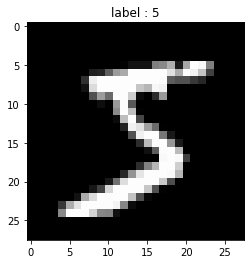

In [3]:
print("mnist_train 길이 : ", len(mnist_train))
print("mnist_test 길이 : ", len(mnist_test))

# 데이터 하나 형태
image, label = mnist_train.__getitem__(0)
print("image data 형태 : ", image.size())
print("label : ", label)

# 그리기
img = image.numpy() # image 타입을 numpy 형태로 변환 (1, 28, 28)
plt.title("label : %d" %label)
plt.imshow(img[0], cmap = 'gray')
plt.show()

# MNIST data 띄워보기

5
torch.Size([1, 28, 28])
5


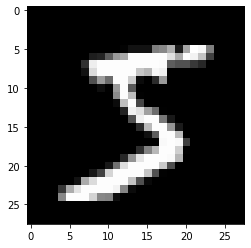

0


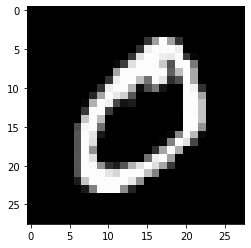

4


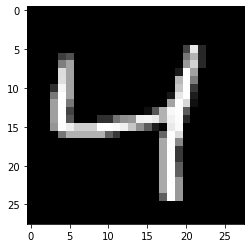

In [4]:
print(mnist_train[0][1])
print(mnist_train[0][0].size())

for i in range(3):
  img = mnist_train[i][0].numpy()
  print(mnist_train[i][1])
  plt.imshow(img[0], cmap = 'gray')
  plt.show()

# convolution 하나 씌워보기

torch.Size([1, 1, 28, 28])
5
torch.Size([1, 3, 28, 28])


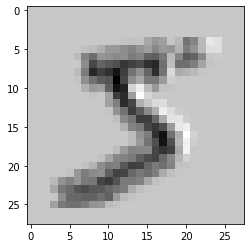

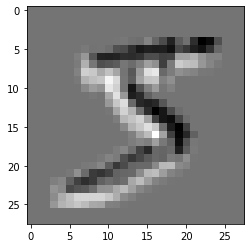

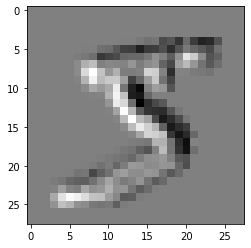

In [5]:
from importlib import invalidate_caches
# mnist의 첫번째 이미지, 라벨 가져오기
image, label = mnist_train[0]
# view: tensor의 사이즈 조절 , -1: 해당 차원 확장시켜라
# [1, 28, 28] -> [1, 1, 28, 28]
image = image.view(-1, image.size()[0], image.size()[1], image.size()[2])
print(image.size())

print(label)

# convolution filter의 정의
conv_layer = nn.Conv2d(in_channels = 1, 
                       out_channels = 3,
                       kernel_size = 3,
                       padding = 1)
# image에 filter 적용
output = conv_layer(Variable(image))
print(output.size())

for i in range(3):
  plt.imshow(output[0, i, :, :].data.numpy(), cmap = 'gray')
  plt.show()

# CNN 만들기 
### train, test data 가져오기

In [6]:
import numpy as np
import torch.optim as optim

batch_size = 16
learning_rate = 0.0002
num_epoch = 10  # 1000

In [9]:
# 후에 학습시킬 때 batch_size 단위로 학습시켜나감
train_loader = torch.utils.data.DataLoader(list(mnist_train)[:batch_size*100],
                                           batch_size = batch_size,
                                           shuffle = True,
                                           num_workers = 2,
                                           drop_last = True) # batch_size 만큼 나눌 때 나머지는 버려라

test_loader = torch.utils.data.DataLoader(mnist_test,
                                          batch_size = batch_size,
                                          shuffle = False,
                                          num_workers = 2,
                                          drop_last = True)                                         

# CNN 클래스 만들기 (모델 만들기)

In [10]:
class CNN(nn.Module): # nn.Module 상속 받음
  def __init__(self):
    super(CNN, self).__init__() # 28 * 28
    self.layer = nn.Sequential(
        nn.Conv2d(1, 16, 5, padding = 2),
        nn.ReLU(),

        nn.Conv2d(16, 32, 5, padding = 2), # 28 * 28
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # 28 * 28 -> 14 * 14

        nn.Conv2d(32, 64, 5, padding = 2), # 14 * 14
        nn.ReLU(),
        nn.MaxPool2d(2, 2) # 14 * 14 -> 7 * 7
    )

    self.fc_layer = nn.Sequential(
        nn.Linear(64*7*7, 100),
        nn.ReLU(),
        nn.Linear(100, 10)
    )

  def forward(self, x):
    out = self.layer(x)
    out = out.view(batch_size, -1)
    out = self.fc_layer(out)
    return out

model = CNN() # .cuda()

In [13]:
# 파라미터 체크하기 
for parameter in model.parameters():
  # print(parameter)
  print(parameter.shape)

torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([100, 3136])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [15]:
# loss function, optimizer 선언
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


# optimization

In [16]:
for i in range(num_epoch):
  for j, [image, label] in enumerate(train_loader): # batch_size만큼
    x = Variable(image) # .cuda()
    y_ = Variable(label) # .cuda()

    optimizer.zero_grad() # optimizer 안에서 이전 gradient들을 초기화
    output = model.forward(x)
    loss = loss_func(output, y_)
    loss.backward() # gradient 계산
    optimizer.step() # parameter 업데이트

    if j % 50 == 0:
      print(loss, j, i)

tensor(2.2975, grad_fn=<NllLossBackward0>) 0 0
tensor(1.9641, grad_fn=<NllLossBackward0>) 50 0
tensor(0.3225, grad_fn=<NllLossBackward0>) 0 1
tensor(0.4515, grad_fn=<NllLossBackward0>) 50 1
tensor(0.1724, grad_fn=<NllLossBackward0>) 0 2
tensor(0.3727, grad_fn=<NllLossBackward0>) 50 2
tensor(0.4821, grad_fn=<NllLossBackward0>) 0 3
tensor(0.3032, grad_fn=<NllLossBackward0>) 50 3
tensor(0.1330, grad_fn=<NllLossBackward0>) 0 4
tensor(0.7389, grad_fn=<NllLossBackward0>) 50 4
tensor(0.0158, grad_fn=<NllLossBackward0>) 0 5
tensor(0.0958, grad_fn=<NllLossBackward0>) 50 5
tensor(0.1089, grad_fn=<NllLossBackward0>) 0 6
tensor(0.1825, grad_fn=<NllLossBackward0>) 50 6
tensor(0.1430, grad_fn=<NllLossBackward0>) 0 7
tensor(0.2431, grad_fn=<NllLossBackward0>) 50 7
tensor(0.0134, grad_fn=<NllLossBackward0>) 0 8
tensor(0.0034, grad_fn=<NllLossBackward0>) 50 8
tensor(0.0150, grad_fn=<NllLossBackward0>) 0 9
tensor(0.0830, grad_fn=<NllLossBackward0>) 50 9


In [19]:
# 모델 저장시키기
torch.save(model, './mycnn_model_%d.pkl' %(num_epoch))

In [21]:
try:
  # 미리 학습시킨 네트워크의 파라미터 집합 [피클]
  model = torch.load('./mycnn_model_10.pkl')
  print("model restored")
except:
  print("model not restored")

model restored


In [22]:
def ComputeAccr(dloader, imodel):
  correct = 0
  total = 0

  for j, [imgs, labels] in enumerate(dloader) : # batch_size 만큼
    img = Variable(imgs) # .cuda() # x
    label = Variable(labels) # y
    # label = Variable(labels).cuda()

    output = imodel.forward(img) # forward prop.
    _, output_index = torch.max(output, 1)

    total += label.size(0)
    correct += (output_index == label).sum().float()

  print("Accuracy of Test Data {}".format(100 * correct / total))

In [23]:
ComputeAccr(test_loader, model)

Accuracy of Test Data 93.19999694824219
